In [1]:

import time
import pandas as pd
import glob
import numpy as np
import timeit
import pickle
import ast
from datetime import datetime
from collections import Counter
from scipy import stats
import re

pd.options.mode.chained_assignment = None  # default='warn'

from multiprocessing import Pool
from matplotlib import pyplot as plt
def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
start_time = timeit.default_timer()

# import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
#matplotlib.rcParams.update({'font.size': 18})

path_dicts='/mnt/sdb1/sandeep/dicts_chess/'

# with open(file_to_read) as f:
#     exec(f.read())
    
# import ast


In [74]:
p=Pool(processes=15)
names=path_dicts+"parquets/a_sorted_full_careers*"

# names=path_dicts+"parquets/dict_full_careers*" # all files
files=sorted(glob.glob(names))
df_careers = pd.concat(p.map(pd.read_parquet,files),ignore_index=True)
# df_careers = pd.read_parquet(names)

print('loaded careers=',toc(start_time))


p.close()

17426.185051947832
loaded careers= None


### Finding career start and ends within the dataframe

In [75]:
ids=np.array(df_careers['player_id'])
ind=np.where(~(ids[1:ids.shape[0]]==ids[0:ids.shape[0]-1]))
ind=ind[0]
career_lens=ind[1:len(ind)]-ind[0:len(ind)-1]
print(sum(np.array(career_lens)>100))
ind=[0]+list(ind)
len(ind)

208699


978868

###  Top 3 frequent openings vs win rates (as white) without first 100 games

In [ ]:
from collections import Counter
store_entropy_op=[]
store_ind=[]
t_ic = time.time();
fig = plt.figure(0,figsize=(10, 8));
plot_num=0;n_plots=4
career_in_focus=305000
# for it in range(len(ind)-1):
for it in range(career_in_focus,career_in_focus+10000):

    if it % 1000 == 0:
        t_oc = time.time();
        print('career number=','-----',it/(len(ind)-1))
        with open("/mnt/sdb1/sandeep/0. Careers in chess/a_entropy_calc.txt", "a") as file_object:
            file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     print('career=',it/(len(ind)-1),end='\r')
    df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
    df_career_it=df_career_it[df_career_it['event_type']=='Rated Classical game'];
    df_career_it["op_short"]=df_career_it.opening_.str.split(':').str[0]
    df_career_it_white=df_career_it[df_career_it['is_white']==1]
    
    if df_career_it_white.shape[0]>500:
        df_career_it_white=df_career_it_white.iloc[100:df_career_it_white.shape[0],:] # ignoring first 100 games 
        df_op_counts=df_career_it_white.groupby(['op_short']).count();        df_op_wins=df_career_it_white[df_career_it_white['won_']==1].groupby(['op_short']).count();
        df_op_counts=df_op_counts.sort_values(['player_id'],ascending=False);        
        df_op_counts=df_op_counts.iloc[0:3,:] # TOP 3 MOST FREQUENT OPENING ONLY
        # df_op_counts=df_op_counts[df_op_counts['player_id']>50];
        op_counts=np.array(df_op_counts.iloc[:,0]);  
        wins_=[]
        for key_ in df_op_counts.index:
            if key_ in df_op_wins.index:
                ind_op=np.where(df_op_wins.index==key_)
                wins_.append(df_op_wins.iloc[ind_op[0][0],0])
            else:
                wins_.append(0)
        wins_=np.array(wins_)

        #------------------------------------------------
        # PLOT
        #------------------------------------------------
        plot_num=plot_num+1;
        
        ax = fig.add_subplot(n_plots, n_plots, plot_num);
        if (plot_num-1)%(n_plots)==0:
            ax.set(ylabel=r'% win rate');
        if (plot_num)>(n_plots*(n_plots-1)):
            ax.set(xlabel=r"number of times opening is played ");

        ax.plot(op_counts,100*np.divide(wins_,op_counts),'.-');
        # ax.legend(store_lines,leg_,loc=(1.04,0));
            
        # ax.set_yscale('log',base=10)
    if plot_num>n_plots*n_plots-1:
        break


In [266]:
df_career_it

,player_id,event_type,time_control,white_player,black_player,result_,utcdate,utctime,whiteelo,blackelo,opening_,actual_game_,termination_,is_white,won_,op_short,ELO_gap


### Opening entropy vs ELO

### Response to weaker vs stronger players

In [ ]:

GAP_=50 # Opponnents with ELO gap 10 anbove or below are considered
store_entropyH=[]
store_entropyL=[]
store_rating=[]
store_ind=[]
t_ic = time.time();

career_in_focus=500000
# for it in range(len(ind)-1):
for it in range(career_in_focus):

    if it % 200 == 0:
        t_oc = time.time();
        print('career number=','-----',it,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/a_entropy_calc.txt", "a") as file_object:
#             file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     print('career=',it/(len(ind)-1),end='\r')
    df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
    df_career_it=df_career_it[df_career_it['event_type']=='Rated Blitz game'];
    df_career_it["op_short"]=df_career_it.opening_.str.split(':').str[0]
    df_career_it=df_career_it[df_career_it['termination_']=='Normal']
    df_career_it=df_career_it[~df_career_it.whiteelo.isin(['?',np.NaN])]
    df_career_it=df_career_it[~df_career_it.blackelo.isin(['?',np.NaN])]
    df_career_it['whiteelo']=pd.to_numeric(df_career_it['whiteelo'])
    df_career_it['blackelo']=pd.to_numeric(df_career_it['blackelo'])
    df_career_it['ELO_gap']=df_career_it['whiteelo']-df_career_it['blackelo']
    
    df_career_it["ELO_gap"]=np.where(df_career_it['is_white']==1,df_career_it["ELO_gap"],-df_career_it["ELO_gap"])

    df_against_higher=df_career_it[df_career_it["ELO_gap"]>=GAP_]
    df_against_lower=df_career_it[df_career_it["ELO_gap"]<=-GAP_]
    
    df_whiteH=df_against_higher[df_against_higher['is_white']==1]
    df_whiteL=df_against_lower[df_against_lower['is_white']==1]
#     df_career_it_black=df_career_it[df_career_it['is_white']==0]

    temp_rating=[]
    is_white=1 # CHAHNGE FOR BLACK
    if (df_whiteH.shape[0]>200) and (df_whiteL.shape[0]>200):

        temp_rating=list(df_whiteH.iloc[:,9-is_white])
#         df_op_counts=df_whiteH.groupby(['opening_']).count();
        df_op_counts=df_whiteH.groupby(['op_short']).count();
        
        op_counts=np.array(df_op_counts.iloc[:,0]);   
        prob_=op_counts/np.sum(op_counts)
        entropy_=-np.sum(np.multiply(prob_,np.log2(prob_)))
        temp_rating=[int(x) for x in temp_rating if (not(x== np.NaN) and not(x== '?'))]
        store_ind.append(ind[it])
        store_rating.append(np.mean(np.array(temp_rating)))

        store_entropyH.append(entropy_)
        
        # STORING ENTROPY FOR LOWER
#         df_op_counts=df_whiteL.groupby(['opening_']).count();
        df_op_counts=df_whiteL.groupby(['op_short']).count();
        op_counts=np.array(df_op_counts.iloc[:,0]);   
        prob_=op_counts/np.sum(op_counts)
        entropy_=-np.sum(np.multiply(prob_,np.log2(prob_)))

        store_entropyL.append(entropy_)
#         store_higher
        
#------------------------------------------------
# PLOT
#------------------------------------------------
t_oc = time.time();
print(t_oc-t_ic,' seconds')

[CONTROL FOR GAME LENGTHS]

## Currently I am not saving the opening entropy of each agent to file
## *I should save it as a dictionary with username as key and  op entropy as value*
- do it two times for main opening vs opening lines
- also save the total number of games by player as white and as black (for filtering later)
- convert to pandas dataframe and save

4109
0<ELO<1600 vs 1600<ELO<1900 
 KstestResult(statistic=0.04817126819543597, pvalue=0.040027150189655525)
1600<ELO<1900 vs 1900<ELO<2473 
 KstestResult(statistic=0.0925583414610938, pvalue=0.0003537488790139598)
0<ELO<1600 vs 1900<ELO<2473 
 KstestResult(statistic=0.1126114769439827, pvalue=1.927506141863322e-05)


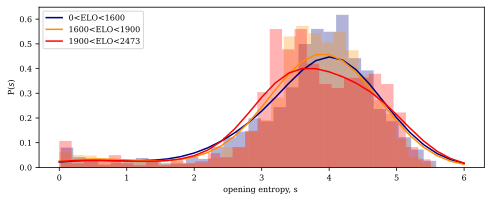

In [99]:
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}


#------------------------------------------------------
print(len(store_entropyH))
bins_=30
store_rating=np.array(store_rating);
store_entropyH=np.array(store_entropyH);
store_entropyL=np.array(store_entropyL);
colors = ['navy', 'darkorange','red', 'cornflowerblue']

ELO_bins_=[0,1600,1900,int(np.floor(max(store_rating)))]

# labels_ = ['ELO < 1500', '1500 < ELO < 1800 ', 'ELO > 1800']
labels_=[str(ELO_bins_[x])+'<ELO<'+str(ELO_bins_[x+1]) for x in range(len(ELO_bins_)-1)]
nn=31
fig = plt.figure(0,figsize=(8, 6.5));
ax = fig.add_subplot(2, 1, 1);

store_for_test=[]
for it_bin in range(len(ELO_bins_)-1):
    high_ind=np.where((store_rating>ELO_bins_[it_bin])&(store_rating<ELO_bins_[it_bin+1]));high_ind=high_ind[0]
    X=store_entropyL[high_ind]
    store_for_test.append(X)
    X=X.reshape(-1, 1)
    p_=ax.hist(X,bins_,alpha=.3,density=True,color=colors[it_bin]);
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    s = np.linspace(0,6,nn)
    log_dens = kde.score_samples(s.reshape(-1,1))
    ax.plot(s,np.exp(log_dens),color=colors[it_bin],label=labels_[it_bin])


# ax.hist(store_entropyL[high_ind],bins_,alpha=.3,density=True);
# ax.legend(store_lines,leg_,loc=(1.04,0));
ax.set(xlabel=r"opening entropy (against stronger vs weaker opponent), s ", ylabel=r'P($s$)');

ax.set(xlabel=r"opening entropy, s ", ylabel=r'P($s$)');

for it_bin in range(len(ELO_bins_)-2):
    print(labels_[it_bin]+' vs '+ labels_[it_bin+1],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+1]))
it_bin=0
print(labels_[it_bin]+' vs '+ labels_[it_bin+2],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+2]))

# print('12',stats.ks_2samp(store_for_test[1],store_for_test[2]))
# print('02',stats.ks_2samp(store_for_test[0],store_for_test[2]))

ax.legend(loc='upper left');


# ax = fig.add_subplot(2, 1, 2);
# ax.hist(store_rating,bins_,alpha=.3);

# ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));

In [101]:
len(store_entropyL)

4109

# Piece movement - Better players move their pieces differently?
- *ensure that your code works on games which have evaluation*
- deal with games with no known players, they appear conjoined with other games

## New list with games with numbers removed

In [2]:
# import re
# games_=list(df_careers.iloc[:,11])
# t_ic = time.time();

# new_games=[]
# career_in_focus=len(games_)
# for it_game in range(career_in_focus):
#     game_=games_[it_game]
#     game_=re.split(' ' ,game_)
    
#     a=1;game__=[]
#     for x in game_:
        
#         if x.startswith(str(a)):
#             a=a+1
#         else:
#             game__.append(x)
#     game__
#     y=''
#     for x in game__:
#         y=y+x+','
#     new_games.append(y)
#     if it_game % 100000 == 0:
#         t_oc = time.time();
#         print('career number=','-----',it_game/(career_in_focus),it_game,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING02.txt", "a") as file_object:
#             file_object.write('--'+str(it_game/(career_in_focus))+'--'+str(it_game/(career_in_focus))+'--i.e.-'+str(it_game)+'/'+str(career_in_focus)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
# with open(path_dicts+'actual_games_all.pkl', 'wb') as f:
#     pickle.dump(new_games, f)

          



In [ ]:
#---------------------------------
# Loading saved file
#---------------------------------

with open(path_dicts+'actual_games_all.pkl', 'rb') as f:
    new_games = pickle.load(f)

df_careers.shape[0]# Analysis of moves in games (total points in begining = 39x2)
- control for game length
- if sum(a) or sum(b) ==0 ; dont consider the game because then number of total moves<2

In [ ]:
# t_ic = time.time();
# career_in_focus=len(new_games)
# # career_in_focus=int(.35*100000)


# store_game_lens=np.zeros([career_in_focus])
# store_a=np.zeros([career_in_focus,6])
# store_b=np.zeros([career_in_focus,6])


# for it_game in range(career_in_focus):

#     game_=new_games[it_game]
#     game_=re.split(',',game_)
#     L=len(game_)
#     store_game_lens[it_game]=(L-2)

#     if L<600:
#         gameW=game_[0:L-2:2]
#         La=len(gameW)
#         y='';
#         for x in gameW:
#             y=y+x+','
#         gameW=y
#         gameB=game_[1:L-2:2]
#         Lb=len(gameB)
#         y='';
#         for x in gameB:
#             y=y+x+','
#         gameB=y
#         pieces_=['N','B','R','Q','K']
#         a=[];b=[];
#         if not(La==0) and not(Lb==0):
#             for piece_ in pieces_:
#                     a.append(gameW.count(piece_)/La)
#                     b.append(gameB.count(piece_)/Lb)
#             a.append(1-sum(a));  b.append(1-sum(b))

#         else:
#             a=[0,0,0,0,0,0];b=[0,0,0,0,0,0];
#     else:
#         a=[0,0,0,0,0,0];b=[0,0,0,0,0,0];

#     store_a[it_game]=a;store_b[it_game]=b

#     if it_game % 50000== 0:
#         t_oc = time.time();
#         print('career number=','-----',it_game/(career_in_focus),it_game,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING.txt", "a") as file_object:
#             file_object.write('--'+str(it_game/(career_in_focus))+'--i.e.-'+str(it_game)+'/'+str(career_in_focus)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')



In [ ]:
# store_game_lens=np.array(store_game_lens)

# with open(path_dicts+'store_game_lengths.pkl', 'wb') as f:
#     pickle.dump(store_game_lens, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------game_lengths-------\n')

# store_a=np.array(store_a)


# with open(path_dicts+'store_white_piece_activity.pkl', 'wb') as f:
#     pickle.dump(store_a, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------white activity-------\n')
# store_b=np.array(store_b)
    
# with open(path_dicts+'store_black_piece_activity.pkl', 'wb') as f:
#     pickle.dump(store_b, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------black activity-------\n')


In [2]:
          
#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'store_white_piece_activity.pkl', 'rb') as f:
    store_a = pickle.load(f)
    
with open(path_dicts+'store_black_piece_activity.pkl', 'rb') as f:
    store_b = pickle.load(f)

with open(path_dicts+'store_game_lengths.pkl', 'rb') as f:
    store_game_lens = pickle.load(f)


## store acitivty of different pieces in 6 differnt numpy array and write to file
-----------------------------------------
## saves RAM

In [16]:
# pieces_=['N','B','R','Q','K','P']
# for it in range(store_a.shape[1]):
#     with open(path_dicts+'store_activity_of_white_'+pieces_[it]+'.pkl', 'wb') as f:
#         pickle.dump(store_a[:,it], f)
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING2.txt", "a") as file_object:
#         file_object.write('-------activity piece by piece-------\n')
 
# for it in range(store_b.shape[1]):
#     with open(path_dicts+'store_activity_of_black_'+pieces_[it]+'.pkl', 'wb') as f:
#         pickle.dump(store_b[:,it], f)
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING2.txt", "a") as file_object:
#         file_object.write('-------activity piece by piece-------\n')
 




## list of ELOs of the players in the game

In [6]:
# list_ELO=np.where(df_careers['is_white']==1,df_careers['whiteelo'],df_careers['blackelo'])
# list_ELO2=[]
# for x in list_ELO:
#     if (not(x== np.NaN) and not(x== '?')):
#         list_ELO2.append(int(x))
#     else:
#         list_ELO2.append(-1)
# list_ELO2=np.array(list_ELO2)
# with open(path_dicts+'store_all_ELOs.pkl', 'wb') as f:
#     pickle.dump(list_ELO2, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------stored ELO list-------\n')
          


In [3]:
#---------------------------------
# Loading saved file
#---------------------------------
    
with open(path_dicts+'store_all_ELOs.pkl', 'rb') as f:
    list_ELO2 = pickle.load(f)

### Filtering the games into 
- high
- mid
- low

 ELO

In [4]:
ELO_bins_=[0,1600,1900,int(np.floor(max(list_ELO2)))]
store_ind_for_ELO=[]

for it_bin in range(len(ELO_bins_)-1):
    high_ind=np.where((list_ELO2>ELO_bins_[it_bin])&(list_ELO2<ELO_bins_[it_bin+1]));
    high_ind=high_ind[0]
    store_ind_for_ELO.append(high_ind)



array([1557, 1538, 1522, ..., 1500, 1678, 1500])

In [5]:
store_game_lens=np.array(store_game_lens)
   
filtered_game_len=[]
for it_bin in range(len(ELO_bins_)-1):
    filtered_game_len.append(store_game_lens[store_ind_for_ELO[it_bin]])
    
activity_=[]
for it_bin in range(len(ELO_bins_)-1):
    activity_.append(store_a[store_ind_for_ELO[it_bin]])
    
        


In [18]:
filtered_game_len

array([array([ 56.,  82.,  75., ...,  93., 280.,  50.]),
       array([ 36.,  74.,  56., ..., 116.,  42.,  22.]),
       array([101., 126.,  73., ...,  93.,  74., 107.])], dtype=object)

moves between  40  and  60


array([0.08      , 0.15384615, 0.07692308, ..., 0.0952381 , 0.08      ,
       0.        ])

In [28]:
activity_[1]

array([0.18918919, 0.13513514, 0.05405405, 0.37837838, 0.        ,
       0.24324324])

#         pieces_=['N','B','R','Q','K','Pawn']


In [ ]:
filtered_game_len

moves between  50  and  80
100000
moves between  50  and  80
100000
moves between  50  and  80
100000
0<ELO<1600 vs 1600<ELO<1900 
 KstestResult(statistic=0.013360000000000039, pvalue=3.509003405005293e-08)
1600<ELO<1900 vs 1900<ELO<3113 
 KstestResult(statistic=0.03298000000000001, pvalue=1.1038352389604042e-47)
0<ELO<1600 vs 1900<ELO<3113 
 KstestResult(statistic=0.03883, pvalue=6.117080174477606e-66)


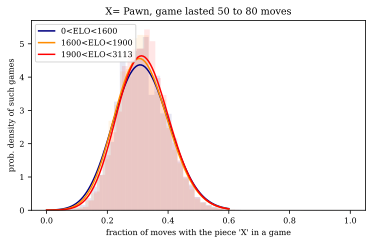

In [73]:

from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

#-------------------------------------------------------
PIECE_ID=5
pieces_=['Knight','Bishop','Rook','Queen','King','Pawn']

#-------------------------------------------------------


filtered_game_len=np.array(filtered_game_len)
MOVES_bins_=[10,20,30,50,80,100,150]
it_MOVES_bin=3
#------------------------------------------------------
bins_=51
TOTAL_GAMES_CONSIDERED_FOR_PLOT=100000

colors = ['navy', 'darkorange','red', 'cornflowerblue']
labels_=[str(ELO_bins_[x])+'<ELO<'+str(ELO_bins_[x+1]) for x in range(len(ELO_bins_)-1)]

nn=101
fig = plt.figure(0,figsize=(6, 3.5));
ax = fig.add_subplot(1, 1, 1);

store_for_test=[]
for it_bin in range(len(ELO_bins_)-1):
    ind_=np.where((filtered_game_len[it_bin]>=MOVES_bins_[it_MOVES_bin]) & (filtered_game_len[it_bin]<MOVES_bins_[it_MOVES_bin+1]));
    print('moves between ',MOVES_bins_[it_MOVES_bin],' and ',MOVES_bins_[it_MOVES_bin+1])

    X=activity_[it_bin][:,PIECE_ID][ind_]
    TILL_= min(TOTAL_GAMES_CONSIDERED_FOR_PLOT,len(X))
    # I take the number of points = TOTAL_GAMES if size X > size TOTAL_GAMES
    X=X[0:TILL_]
    store_for_test.append(X)
    print(TILL_)
    X=X.reshape(-1, 1)
    p_=ax.hist(X,bins_,alpha=.1,density=True,color=colors[it_bin]);
    kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(X)
    s = np.linspace(0,.6,nn) # This is the xrange
    log_dens = kde.score_samples(s.reshape(-1,1))
    ax.plot(s,np.exp(log_dens),color=colors[it_bin],label=labels_[it_bin])


# ax.hist(store_entropyL[high_ind],bins_,alpha=.3,density=True);
title_='X= '+pieces_[PIECE_ID]+', game lasted '+str(MOVES_bins_[it_MOVES_bin])+' to '+ str(MOVES_bins_[it_MOVES_bin+1])+' moves'

ax.set_title(title_);

ax.set(xlabel=r"fraction of moves with the piece 'X' in a game", ylabel=r'prob. density of such games');

for it_bin in range(len(ELO_bins_)-2):
    print(labels_[it_bin]+' vs '+ labels_[it_bin+1],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+1]))
it_bin=0
print(labels_[it_bin]+' vs '+ labels_[it_bin+2],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+2]))

# print('12',stats.ks_2samp(store_for_test[1],store_for_test[2]))
# print('02',stats.ks_2samp(store_for_test[0],store_for_test[2]))

ax.legend(loc='upper left');


# ax = fig.add_subplot(2, 1, 2);
# ax.hist(store_rating,bins_,alpha=.3);

# ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));

## Hot-streaks

In [113]:
# won_=np.array(df_careers['won_'])
# game_type=np.array(df_careers['event_type'])

# game_type_simplified=game_type.copy()
# it=0
# for game_ in game_type:
    
#     if 'Blitz' in game_:
#         game_type_simplified[it]='Blitz'
#     elif 'Bullet' in game_:
#         game_type_simplified[it]='Bullet'
#     elif 'Classical' in game_:
#         game_type_simplified[it]='Classical'
#     elif 'Standard' in game_:
#         game_type_simplified[it]='Standard'
#     elif 'Correspondence' in game_:
#         game_type_simplified[it]='Correspondence'
#     else:
#         game_type_simplified[it]=-1
#     it=it+1
    
        

In [119]:

# with open(path_dicts+'game_type_simplified.pkl', 'wb') as f:
#     pickle.dump(game_type_simplified, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------game_type_simplified-------\n')

#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'game_type_simplified.pkl', 'rb') as f:
    game_type_simplified = pickle.load(f)
    

# #-------------------------------------------------------------------------------------------

# with open(path_dicts+'game_won_.pkl', 'wb') as f:
#     pickle.dump(won_, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------won_-------\n')

#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'game_won_.pkl', 'rb') as f:
    won_ = pickle.load(f)
    

    

In [80]:
df_careers

,player_id,event_type,time_control,white_player,black_player,result_,utcdate,utctime,whiteelo,blackelo,opening_,actual_game_,termination_,is_white,won_
0,-1,Rated Blitz game,300+2,-1,JoseChez,0-1,2013-01-01 13:59:17,13:59:17,1557,1338,Pirc Defense #4,1. e4 d6 2. Bc4 Nf6 3. d3 g6 4. Bg5 Bg7 5. h4 ...,Normal,1,0.0
1,-1,Rated Blitz game,300+2,-1,WealthandTaste,0-1,2013-01-01 14:09:42,14:09:42,1538,1394,Robatsch (Modern) Defense,1. e4 g6 2. d4 Bg7 3. e5 e6 4. Nf3 b6 5. Bg5 f...,Normal,1,0.0
2,-1,Rated Blitz game,300+2,-1,alex296,1-0,2013-01-01 14:21:30,14:21:30,1522,1302,"Italian Game: Classical Variation, Giuoco Pian...",1. e4 e5 2. Bc4 Nc6 3. d3 Nf6 4. c3 Bc5 5. Nf3...,Normal,1,1.0
3,-1,Rated Blitz game,300+2,-1,jemioloch,1-0,2013-01-02 15:42:50,15:42:50,1528,1200,Bishop's Opening,1. e4 e5 2. Bc4 Qe7 3. d3 d6 4. Nf3 Be6 5. h3 ...,Normal,1,1.0
4,-1,Rated Blitz game,300+2,-1,jmcd,0-1,2013-01-02 15:49:35,15:49:35,1531,1417,King's Pawn Game,1. e4 e5 0-1\n,Time forfeit,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246158051,zwzdhwd,Rated Bullet game,30+0,zwzdhwd,aleks63,0-1,2016-12-31 19:17:16,19:17:16,1665,2103,Pirc Defense #4,1. e4 d6 2. Nf3 Nf6 3. Bc4 e6 4. Bb3 Nxe4 5. d...,Time forfeit,1,0.0
246158052,zwzdhwd,Rated Bullet game,30+0,zwzdhwd,aleks63,0-1,2016-12-31 19:18:49,19:18:49,1658,2105,Van't Kruijs Opening,1. e3 d6 2. d4 Nf6 3. Nc3 g6 4. Bb5+ c6 5. Bd3...,Normal,1,0.0
246158053,zx3t,Rated Blitz game,180+0,zx3t,CHEMENGER,1-0,2016-12-31 15:44:45,15:44:45,1500,1507,Petrov's Defense,1. e4 { [%eval 0.23] } 1... e5 { [%eval 0.31] ...,Normal,1,1.0
246158054,zx3t,Rated Blitz game,180+0,zx3t,zzzllzzz,0-1,2016-12-31 16:31:34,16:31:34,1678,1738,Caro-Kann Defense,1. e4 c6 2. Nf3 d5 3. exd5 cxd5 4. d4 Nf6 5. N...,Normal,1,0.0


## To find bluders in evaluated games
- if (XX in game_)==1: 

where XX ='?'

### you will need to separate games by blitz, bullet, classical

### Only keeping games with normal ending

In [5]:
# df_normal_careers=df_careers[df_careers['termination_']=='Normal']
# # 

In [369]:
# fig = plt.figure(0,figsize=(6, 3.5));
# ax = fig.add_subplot(1, 1, 1);
# ax.plot(store_rating);
# ax.set_yticks(list(np.linspace(0,1500,16)));
# store_rating
# store_rating

(60894356, 15) (246158056, 15)


246158056


### Player ELO vs time

<ipython-input-25-6f3d7f513785>:40: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0,00);


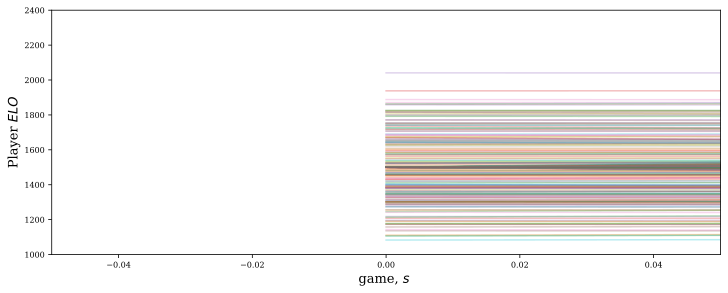

In [25]:

t_ic = time.time();
#------------------------------------------------
# PLOT
#------------------------------------------------
fig = plt.figure(0,figsize=(12, 4.5));
ax = fig.add_subplot(1, 1, 1);

# for it in range(len(ind)-1):
X=3000;nn=1000
for it in range(X,X+nn):

    if it % 10000 == 0:
        t_oc = time.time();
#         print('MONTH=','-----',it/(len(ind)-1))
        with open("/mnt/sdb1/sandeep/0. Careers in chess/a_OP_entropy_calc.txt", "a") as file_object:
            file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
    df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
    df_career_it_classical=df_career_it[df_career_it['event_type']=='Rated Blitz game']
#     df_career_it_white=df_career_it[df_career_it['is_white']==1]
    store_rating=[]

    if df_career_it_classical.shape[0]>10:
        for it_game in range(df_career_it_classical.shape[0]):
            is_white=df_career_it_classical.iloc[it_game,13]
            rating_=df_career_it_classical.iloc[it_game,9-is_white]
            store_rating.append(rating_)
        if not('?' in store_rating):
            
            store_rating=[int(x) for x in store_rating]

            ax.plot(store_rating,alpha=.3);
            # ax.legend(store_lines,leg_,loc=(1.04,0));
            ax.set_xlabel(r"game, $s$ ",fontsize=13)
            ax.set_ylabel(r'Player $ELO$',fontsize=13)
            ax.set_yticks(list(np.linspace(0,3000,16)));


# ax.set_xscale('log',base=2)
ax.set_ylim(1000,2400);
ax.set_xlim(0,00);

# ax.set_xticks(np.linspace(12,48,4));
# ax.set_xticks(np.linspace(12,48,4));


In [241]:
# pd.options.mode.chained_assignment = None  # default='warn'
# df_career_it["ELO"]=""
# df_career_it["ELO"]=store_rating
# df_career_it.iloc[0:50]

np.sum(np.array(career_lens)>1000)

56130

### Career Lengths based on ind

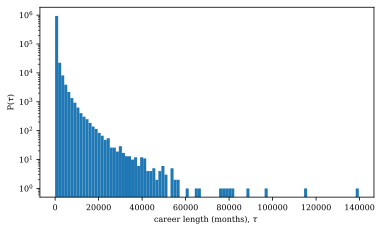

In [157]:

fig = plt.figure(0,figsize=(6, 3.5));
ax = fig.add_subplot(1, 1, 1);

ax.hist(career_lens,100);

# ax.legend(store_lines,leg_,loc=(1.04,0));
ax.set(xlabel=r"career length (months), $\tau$ ", ylabel=r'P($\tau$)');
ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));


### Career lengths in years

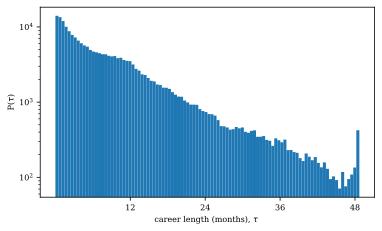

In [125]:
# fig = plt.figure(0,figsize=(6, 3.5));
# ax = fig.add_subplot(1, 1, 1);
# def datetime_to_float(d):
# #     epoch = datetime.utcfromtimestamp(0)
#     total_seconds =  (d).total_seconds()/3600/24/30
#     # total_seconds will be in decimals (millisecond precision)
#     return total_seconds
# X=[datetime_to_float(x) for x in store_career_duration]
# ax.hist(X,100);

# # ax.legend(store_lines,leg_,loc=(1.04,0));
# ax.set(xlabel=r"career length (months), $\tau$ ", ylabel=r'P($\tau$)');
# ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));


### Loading parquets and then adding new columns, sorting and saving them back as parquets.

In [ ]:
# start_time = timeit.default_timer()

# t_ic=time.time()

# for it_ in range(491,492):
#     p=Pool(processes=15)
#     names=path_dicts+"parquets/dict_full_careers"+str(it_)+".parquet"

#     # names=path_dicts+"parquets/dict_full_careers*" # all files
#     files=sorted(glob.glob(names))
# #     df_careers = pd.concat(p.map(pd.read_parquet,files),ignore_index=True)
#     df_careers = pd.read_parquet(names)

#     print('loaded careers=',it_,toc(start_time))
    

#     p.close()

#     #----------------------------------------------------------
#     ### CREATING NEW COLUMNS
#     #----------------------------------------------------------

#     pd.options.mode.chained_assignment = None  # default='warn'
#     # df_careers["is_white"]=""
#     df_careers["is_white"]=np.where(df_careers["white_player"]==df_careers["player_id"],1,0)

#     t_oc=time.time()
# #     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
# #                 file_object.write('IS_WHITE----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


#     conditions  = [ (df_careers["result_"]=='1-0') &(df_careers["is_white"]==1),
#                    (df_careers["result_"]=='0-1') &(df_careers["is_white"]==0),
#                   (df_careers["result_"]=='1/2-1/2')]
#     choices     = [ 1,1,0.5 ]    
#     df_careers["won_"] = np.select(conditions, choices, default=0)
#     t_oc=time.time()
# #     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
# #                 file_object.write('won_----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


#     df_careers["utcdate"]=df_careers["utcdate"]+' '+df_careers["utctime"]

#     t_oc=time.time()
#     # with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#     #             file_object.write('IS_WHITE----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


#     #----------------------------------------------------------
#     ### Merging datetime
#     #----------------------------------------------------------


#     t_oc=time.time()
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#                 file_object.write('start datetime_----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     format_='%Y.%m.%d %H:%M:%S'
#     df_careers["utcdate"]=pd.to_datetime(pd.Series(df_careers["utcdate"]), format=format_)


#     t_oc=time.time()
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#                 file_object.write('finished datetime----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     #----------------------------------------------------------
#     ### Finding career start and ends within the dataframe
#     #----------------------------------------------------------

#     ids=np.array(df_careers['player_id'])
#     ind=np.where(~(ids[1:ids.shape[0]]==ids[0:ids.shape[0]-1]))

#     ind=ind[0]
#     career_lens=ind[1:len(ind)]-ind[0:len(ind)-1]
#     tot_careers_=sum(np.array(career_lens)>500)
#     ind=[0]+list(ind)

#     t_oc=time.time()

#     # with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#     #             file_object.write('np where ind----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
#     #----------------------------------------------------------
#     ### Sorting
#     #----------------------------------------------------------
#     df_careers=df_careers.sort_values(['player_id', 'utcdate'])
#     t_oc=time.time()
# #     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
# #                 file_object.write('SORTED----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     #----------------------------------------------------------
#     ### writing to parquet
#     #----------------------------------------------------------

#     if it_<10:
#         modified_it_='0'+'0'+str(it_)
#     elif (it_<100):
#         modified_it_='0'+str(it_)
#     else:
#         modified_it_=it_
#     names_par=path_dicts+"parquets/a_sorted_full_careers"+str(modified_it_)+".parquet"
#     df_careers.to_parquet(names_par,index=None)


#     t_oc = time.time();
#     print('done=','-----',modified_it_)
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#         file_object.write('--i.e.-'+str(modified_it_)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
    
    
    


        


In [ ]:
# pd.read_csv.engine='python'
# pd.read_csv.sep='\t'
# #----------------------------------------------------------
# ### LOADING CSVS
# #----------------------------------------------------------

# start_time = timeit.default_timer()
# t_ic=time.time()
# t_oc=time.time()
# with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#             file_object.write('LOADING----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
        
# p=Pool(processes=10)
# names=path_dicts+"parquets/0.new_dicts_df_career9*" # all files
# files=sorted(glob.glob(names))
# df_careers = pd.concat(p.map(pd.read_csv,files),ignore_index=True)
# print('loaded careers=',toc(start_time))

# t_oc=time.time()
# with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#             file_object.write('LOADED----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

# p.close()


        
